In [1]:
import os


In [2]:
#directory of data
cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir, 'mask_data')
image_dir = image_dir = os.path.join(data_dir, 'images')
anno_dir = os.path.join(data_dir, 'annotations')


In [3]:
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg' or ".png"]
print(len(image_files))

6024


In [4]:
anno_files = [fname for fname in os.listdir(anno_dir) if os.path.splitext(fname)[-1] == '.json']
print(len(anno_files))

6024


In [5]:
import random
import numpy as np
from PIL import Image
import xml.etree.ElementTree as et
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import json


In [6]:
rnd_idx = random.randint(1, len(image_files))
fname = image_files[rnd_idx]
fpath = os.path.join(image_dir, fname)
image = Image.open(fpath)
image = np.array(image)

anno_name = os.path.splitext(fname)[0]+'.json'
anno_name = os.path.join(anno_dir, anno_name)
with open(anno_name, "r", encoding="utf8") as f: 
    contents = f.read() # string 타입 json_data = json.loads(contents)
    json_data = json.loads(contents)
json_data["Annotations"][0]['classname']


    

'face_no_mask'

In [7]:
class_list = set()
for anno_file in anno_files:
    anno_name = os.path.join(anno_dir, anno_file)
    with open(anno_name, "r", encoding="utf8") as f: 
        contents = f.read() # string 타입 json_data = json.loads(contents)
        json_data = json.loads(contents)
    class_list.add(json_data["Annotations"][0]['classname'])
class_list = list(class_list)
print(len(class_list))    

20


In [8]:
class_list.sort()
class_list

['balaclava_ski_mask',
 'eyeglasses',
 'face_no_mask',
 'face_other_covering',
 'face_shield',
 'face_with_mask',
 'face_with_mask_incorrect',
 'gas_mask',
 'goggles',
 'hair_net',
 'hat',
 'helmet',
 'hijab_niqab',
 'hood',
 'mask_colorful',
 'mask_surgical',
 'other',
 'scarf_bandana',
 'sunglasses',
 'turban']

In [9]:
class2idx = {cls:idx for idx, cls in enumerate(class_list)}
class2idx

{'balaclava_ski_mask': 0,
 'eyeglasses': 1,
 'face_no_mask': 2,
 'face_other_covering': 3,
 'face_shield': 4,
 'face_with_mask': 5,
 'face_with_mask_incorrect': 6,
 'gas_mask': 7,
 'goggles': 8,
 'hair_net': 9,
 'hat': 10,
 'helmet': 11,
 'hijab_niqab': 12,
 'hood': 13,
 'mask_colorful': 14,
 'mask_surgical': 15,
 'other': 16,
 'scarf_bandana': 17,
 'sunglasses': 18,
 'turban': 19}

In [10]:
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'validation')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

In [11]:
image_files.sort()

In [12]:
image_files[:10]

['0001.jpg',
 '0002.png',
 '0003.jpg',
 '0004.jpg',
 '0005.jpg',
 '0006.jpg',
 '0007.jpg',
 '0009.jpg',
 '0010.jpg',
 '0011.jpg']

In [13]:
from numba import jit
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import re
from PIL import Image
import shutil
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
import shutil


In [14]:
#training set and validatoin set creation
cnt = 0
previous_class = ""
for image_file in image_files:
    file_name = os.path.splitext(image_file)[0]
    anno_name = os.path.splitext(file_name)[0]+'.json'
    anno_name = os.path.join(anno_dir, anno_name)
    with open(anno_name, "r", encoding="utf8") as f: 
        contents = f.read() # string 타입 json_data = json.loads(contents)
        json_data = json.loads(contents)
    class_name = json_data["Annotations"][0]['classname']
    if class_name == previous_class:
        cnt += 1
    else:
        cnt = 1
    if cnt <= 20:
        cpath = train_dir
    else:
        cpath = val_dir
    image_path = os.path.join(image_dir, image_file)
    shutil.copy(image_path, cpath)
    previous_class = class_name

In [15]:
train_images = os.listdir(train_dir)
val_images = os.listdir(val_dir)

In [16]:
print(len(train_images), len(val_images))

5868 156


In [17]:
#tf recode

In [18]:
IMG_SIZE = 224
N_TRAIN = len(train_images)
N_VAL = len(val_images)

In [19]:
tfr_dir = os.path.join(data_dir, 'tfrecord')
os.makedirs(tfr_dir, exist_ok=True)

tfr_train_dir = os.path.join(tfr_dir, 'seg_train.tfr')
tfr_val_dir = os.path.join(tfr_dir, 'seg_val.tfr')

In [20]:
writer_train = tf.io.TFRecordWriter(tfr_train_dir)
writer_val = tf.io.TFRecordWriter(tfr_val_dir)

In [21]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [22]:
n_train = 0

train_files = os.listdir(train_dir)
for train_file in train_files:
    train_path = os.path.join(train_dir, train_file)
    image = Image.open(train_path)
    image = image.resize((IMG_SIZE, IMG_SIZE))
    bimage = image.tobytes()
    file_name = os.path.splitext(train_file)[0] #Bangal_101
    anno_name = os.path.splitext(file_name)[0]+'.json'
    anno_name = os.path.join(anno_dir, anno_name)
    with open(anno_name, "r", encoding="utf8") as f: 
        contents = f.read() # string 타입 json_data = json.loads(contents)
        json_data = json.loads(contents)
    class_name = json_data["Annotations"][0]['classname']
    class_num = class2idx[class_name]
    example = tf.train.Example(features=tf.train.Features(feature={
        'image': _bytes_feature(bimage),
        'cls_num': _int64_feature(class_num),
    }))
    writer_train.write(example.SerializeToString())
    n_train += 1
writer_train.close()
print(n_train)

5868


In [23]:
n_val = 0

val_files = os.listdir(val_dir)
for val_file in val_files:
    val_path = os.path.join(val_dir, val_file)
    image = Image.open(val_path)
    image = image.resize((IMG_SIZE, IMG_SIZE))
    bimage = image.tobytes()
    file_name = os.path.splitext(val_file)[0] #Bangal_101
    anno_name = os.path.splitext(file_name)[0]+'.json'
    anno_name = os.path.join(anno_dir, anno_name)
    with open(anno_name, "r", encoding="utf8") as f: 
        contents = f.read() # string 타입 json_data = json.loads(contents)
        json_data = json.loads(contents)
    class_name = json_data["Annotations"][0]['classname']
    class_num = class2idx[class_name]
    example = tf.train.Example(features=tf.train.Features(feature={
        'image': _bytes_feature(bimage),
        'cls_num': _int64_feature(class_num),
    }))
    writer_val.write(example.SerializeToString())
    n_val += 1
writer_val.close()
print(n_val)

156


In [24]:
!ls -1 $tfr-dir

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [25]:
#classification

In [26]:
## Hyper Parameters
N_CLASS = len(class_list)
N_EPOCHS = 20
N_BATCH = 40
IMG_SIZE = 224
learning_rate = 0.0001
steps_per_epoch = N_TRAIN / N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH))

In [27]:
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'cls_num': tf.io.FixedLenFeature([], tf.int64)  
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)    
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32)/255.

    label1 = tf.cast(parsed_features['cls_num'], tf.int64)
    
    return image, label1

In [28]:
## train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=N_TRAIN).prefetch(
    tf.data.experimental.AUTOTUNE).batch(N_BATCH).repeat()

In [29]:
#validation dataset
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH).repeat()

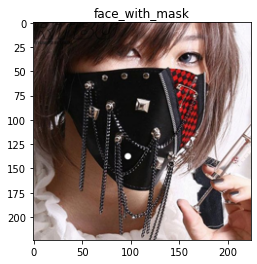

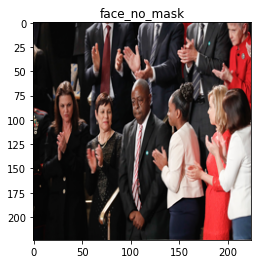

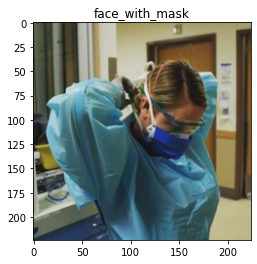

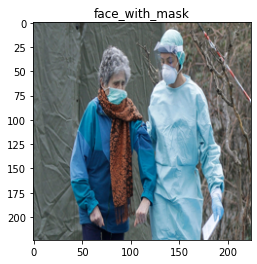

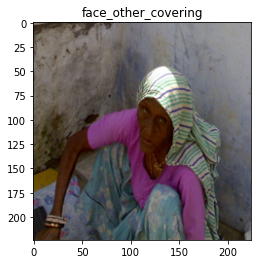

In [32]:
for image, label in train_dataset.take(5):
    plt.imshow(image[0])
    title = class_list[label[0].numpy()]
    plt.title(title)
    plt.show()

In [33]:
#sequential API
def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='SAME', 
                                  input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1024, activation='relu'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(N_CLASS, activation='softmax'))
    return model

In [35]:
## Create model, compile & summary
model = create_model()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 128)      0

In [36]:
history = model.fit(
    train_dataset,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps
)

Epoch 1/20
146/146 [==============================] - 148s 987ms/step - loss: 1.3102 - accuracy: 0.6143 - val_loss: 0.7540 - val_accuracy: 0.8397
Epoch 2/20
146/146 [==============================] - 170s 1s/step - loss: 1.2281 - accuracy: 0.6191 - val_loss: 0.6726 - val_accuracy: 0.8397
Epoch 3/20
146/146 [==============================] - 178s 1s/step - loss: 1.1948 - accuracy: 0.6230 - val_loss: 0.7640 - val_accuracy: 0.8397
Epoch 4/20
146/146 [==============================] - 183s 1s/step - loss: 1.1659 - accuracy: 0.6328 - val_loss: 0.6819 - val_accuracy: 0.8462
Epoch 5/20
146/146 [==============================] - 191s 1s/step - loss: 1.1303 - accuracy: 0.6431 - val_loss: 0.8847 - val_accuracy: 0.7756
Epoch 6/20
146/146 [==============================] - 204s 1s/step - loss: 1.1200 - accuracy: 0.6478 - val_loss: 0.6788 - val_accuracy: 0.8077
Epoch 7/20
146/146 [==============================] - 213s 1s/step - loss: 1.0797 - accuracy: 0.6559 - val_loss: 0.5593 - val_accuracy: 0.8

In [37]:
@jit
def create_bn_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=32, kernel_size=3, padding='SAME', 
                                  input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, padding='SAME'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, padding='SAME'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=256, kernel_size=3, padding='SAME'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=256, kernel_size=3, padding='SAME'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1024))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())    
    model.add(keras.layers.Dense(N_CLASS, activation='softmax'))
    return model

In [38]:
## Create model, compile & summary
model = create_bn_model()

## learning rate scheduing
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=steps_per_epoch*5,
                                                          decay_rate=0.5,
                                                          staircase=True)
model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

C:\Users\jerem\AppData\Local\Temp/ipykernel_18152/807135785.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "create_bn_model" failed type inference due to: Unknown attribute 'Sequential' of type Module(<module 'keras.api._v2.keras' from 'C:\\Users\\jerem\\anaconda3\\lib\\site-packages\\keras\\api\\_v2\\keras\\__init__.py'>)

File "..\..\AppData\Local\Temp\ipykernel_18152\807135785.py", line 3:
<source missing, REPL/exec in use?>

During: typing of get attribute at C:\Users\jerem\AppData\Local\Temp/ipykernel_18152/807135785.py (3)

File "..\..\AppData\Local\Temp\ipykernel_18152\807135785.py", line 3:
<source missing, REPL/exec in use?>

  @jit


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 64)    

C:\Users\jerem\anaconda3\lib\site-packages\numba\core\object_mode_passes.py:151: NumbaWarning: Function "create_bn_model" was compiled in object mode without forceobj=True.

File "..\..\AppData\Local\Temp\ipykernel_18152\807135785.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
C:\Users\jerem\anaconda3\lib\site-packages\numba\core\object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "..\..\AppData\Local\Temp\ipykernel_18152\807135785.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaDeprecationWarning(msg,


In [39]:
history = model.fit(
    train_dataset,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps
)

Epoch 1/20
146/146 [==============================] - 337s 2s/step - loss: 1.7011 - accuracy: 0.5121 - val_loss: 1.2023 - val_accuracy: 0.4167
Epoch 2/20
146/146 [==============================] - 1682s 12s/step - loss: 0.7195 - accuracy: 0.7623 - val_loss: 0.6721 - val_accuracy: 0.8397
Epoch 3/20
146/146 [==============================] - 353s 2s/step - loss: 0.2976 - accuracy: 0.9208 - val_loss: 0.7162 - val_accuracy: 0.8205
Epoch 4/20
146/146 [==============================] - 362s 2s/step - loss: 0.0938 - accuracy: 0.9864 - val_loss: 0.5011 - val_accuracy: 0.8397
Epoch 5/20
146/146 [==============================] - 358s 2s/step - loss: 0.0310 - accuracy: 0.9988 - val_loss: 0.6590 - val_accuracy: 0.7885
Epoch 6/20
146/146 [==============================] - 374s 3s/step - loss: 0.0143 - accuracy: 1.0000 - val_loss: 0.7081 - val_accuracy: 0.8013
Epoch 7/20
146/146 [==============================] - 392s 3s/step - loss: 0.0110 - accuracy: 1.0000 - val_loss: 0.6749 - val_accuracy: 0.83

In [60]:
#save model


In [54]:
model.save('save_model/my_model.tflearn')


INFO:tensorflow:Assets written to: save_model/my_model.tflearn\assets


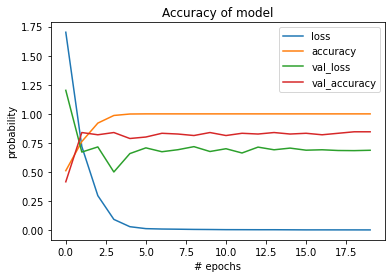

In [116]:
#model evaluation
import pandas as pd
pd.DataFrame(history.history).plot()
plt.title("Accuracy of model")
plt.xlabel("# epochs")
plt.ylabel("probability")
plt.show()


In [190]:
#testing
image = Image.open('mask.jpg')
image = image.resize((224, 224))
image = np.array(image)
image = image/255.

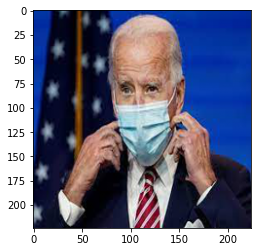

In [191]:
plt.imshow(image)
plt.show()

In [192]:
image = np.reshape(image, (1, 224, 224, 3))

In [193]:
prediction = model.predict(image)
prediction.shape

(1, 20)

In [194]:
prediction

array([[1.4808704e-04, 4.3376791e-04, 3.4388445e-02, 1.8803619e-02,
        7.2049350e-04, 9.2839557e-01, 1.6612879e-03, 6.3620355e-05,
        6.4439948e-05, 2.9087174e-04, 1.9523914e-03, 2.5968012e-04,
        1.2819686e-03, 8.7396574e-04, 1.5631812e-03, 4.0069106e-03,
        4.4669781e-04, 4.0313974e-03, 5.0131039e-04, 1.1222899e-04]],
      dtype=float32)

In [110]:
np.argmax(prediction)

5